Note: This notebook gathers heavily from Lesson 4 of Cutting Edge Deep Learning for Coders: 2018 Edition by Jeremy Howard. I took that notebook and modified it as little as possible to fit the objective of making a Spanish Language Model Classifier.

The task is to classify tweets into one of the following three categories: Positive, Neutral, Negative or None.
For more info: http://www.sepln.org/workshops/tass/2018/task-1/

In [1]:
import sys
sys.path.append("../..")
from fastai.text import *
import html
import json

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

DATA_PATH=Path('../datasets')

OUTPUT_PATH=Path('../output')

WIKILM_PATH=OUTPUT_PATH/'wiki_lm'

TASSLM_PATH=OUTPUT_PATH/'tass_lm'

CLAS_PATH=OUTPUT_PATH/'tass_clas'

In [3]:
%%javascript
// Original source -- https://gist.github.com/xem/670dec8e70815842eb95
Jupyter.beep = () => {
    var A=new AudioContext();
    var o = A.createOscillator();
    o.connect(A.destination);
    o.start(0);
    var duration = 500;
    setTimeout(function(){o.stop(); A.close();}, duration);
}

<IPython.core.display.Javascript object>

## Pre-Process TASS Dataset

Load GeneralTASS Corpus Dataset

In [49]:
import xml.etree.ElementTree as ET

TASS_DATA_PATH = Path(DATA_PATH/'generalTASS')
TRN_PATH = TASS_DATA_PATH/'trn'

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [50]:
e = ET.parse(TRN_PATH/'general-train-tagged-3l.xml')
root = e.getroot()

Check how big our dataset is

In [51]:
print(len(np.array([tweet.find('content').text for tweet in root.findall('tweet')])))

7219


Separate tweets, labels and types into arrays

In [52]:
tweets = np.array([tweet.find('content').text for tweet in root.findall('tweet')])
labels = np.array([tweet.find('sentiments').find('polarity').find('value').text for tweet in root.findall('tweet')])
types = np.array([tweet.find('sentiments').find('polarity').find('type').text for tweet in root.findall('tweet')])

Labels to integers

In [53]:
LABELS = set(labels)
list(LABELS)

['P', 'NONE', 'N', 'NEU']

In [54]:
labels_dict = {}
labels_dict['P'] = 0
labels_dict['N'] = 1
labels_dict['NEU'] = 2
labels_dict['NONE'] = 3
print(labels_dict)

{'P': 0, 'N': 1, 'NEU': 2, 'NONE': 3}


In [55]:
labels = [labels_dict[i] for i in labels]

Some standard pre-processing: We delete all None type tweets, we replace some tokens with more meaningful ones and we shuffle tokens randomly

In [56]:
none_ind = [ind for ind, tweet in enumerate(tweets) if tweet is None]

tweets = np.delete(tweets, none_ind, 0)
labels = np.delete(labels, none_ind, 0)
types = np.delete(types, none_ind, 0)

In [57]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

In [58]:
# Placeholders for hyperlinks and user references
tweets = [['hyp_link' if i.startswith('http://t.co') else 'user_ref' if i.startswith('@') else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([' '.join(i) for i in tweets])

In [59]:
# Prefix for Hashtags
tweets = [[['hash_tag', i] if i.startswith('#') else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [60]:
def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

In [61]:
# Prefix for integers
tweets = [[['int_string', i] if isInt(i) else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [62]:
# Prefix for slang
tweets = [[['que', 'slang_string'] if i=='q' else ['por', 'slang_string'] if i=='x' else ['de', 'slang_string'] if i=='d' else ['Que', 'slang_string'] if i=='Q' else ['Por', 'slang_string'] if i=='X' else ['De', 'slang_string'] if i=='D' else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [63]:
def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string, i] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

In [64]:
# Lol type characters
repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju')]

# Adding prefix to lol type characters
tweets = replace_lol(repl_str, tweets)

In [65]:
np.random.seed(42)

trn_idx = np.random.permutation(len(tweets))

tweets = tweets[trn_idx]
labels = labels[trn_idx]
types = types[trn_idx]

In [66]:
col_names = ['label', 'tweet']

In [67]:
print(tweets[:15])

['user_ref ya nos contarás si explota Europa (como dice Sarkozy)'
 'risa_ja Jajajajajja la mierda del nuevo twitter locooooo me tiene......'
 '"el mejor método de educación es la felicidad...para sufrir, la vida es más que suficiente y yo no le voy a ayudar"'
 'Rajoy viaja en AVE para dar su primer discurso publico, en un mitin en Málaga. Un gesto: no va en el avión de presidente, sino en tren.'
 'RT user_ref Sr. Mas, no garantizar una sanidad publica de calidad universal es anticonstitucional ,por eso no celebra dia constitucion?'
 'Andalucía está comprometida con la estabilidad, pero exigimos lealtad institucional. No discriminar a CCAA por color político hash_tag #debateAND'
 'user_ref user_ref perdona, señor Raul.'
 'Guerra de encuestas! Canal Sur no da la mayoría absoluta al PP, y otras sí.'
 'RT user_ref user_ref charlando con el futbolista Fernando Morientes en hash_tag #Guadalajara, Gala del Deporte hash_tag #CLM hyp_link'
 'A las 11:30 estaré en directo con Carlos Herrera, par

Build validation and training sets

In [68]:
train_limit = int(len(tweets)*0.8)
val_limit = int(len(tweets)*0.9)

In [69]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':labels[:train_limit]}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:val_limit], 'label':labels[train_limit:val_limit]}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets[val_limit:], 'label':labels[val_limit:]}, columns=col_names)

In [70]:
df_trn.head(15)

,label,tweet
0,1,user_ref ya nos contarás si explota Europa (co...
1,1,risa_ja Jajajajajja la mierda del nuevo twitte...
2,2,"""el mejor método de educación es la felicidad...."
3,0,Rajoy viaja en AVE para dar su primer discurso...
4,1,"RT user_ref Sr. Mas, no garantizar una sanidad..."
5,0,Andalucía está comprometida con la estabilidad...
6,2,"user_ref user_ref perdona, señor Raul."
7,2,Guerra de encuestas! Canal Sur no da la mayorí...
8,3,RT user_ref user_ref charlando con el futbolis...
9,3,A las 11:30 estaré en directo con Carlos Herre...


The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun (LINK REQUIRED). Fastai adopts this new format for NLP datasets. In the case of IMDB, there is only one text column.

In [71]:
df_trn[df_trn['label']!=3].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val[df_val['label']!=3].to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst[df_tst['label']!=3].to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in LABELS)

In [72]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':[0]*len(labels[:train_limit])}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:val_limit], 'label':[0]*len(labels[train_limit:val_limit])}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets[val_limit:], 'label':[0]*len(labels[val_limit:])}, columns=col_names)

In [73]:
df_trn.to_csv(TASSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TASSLM_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(TASSLM_PATH/'test.csv', header=False, index=False)

## Tokenize and Standarize General Tokens for TASS Dataset

#TODO: use fast ai functions

Pre-processing using fast.ai functions

In [29]:
chunksize=24000

re1 = re.compile(r'  +')

In [30]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [98]:
df_trn = pd.read_csv(TASSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TASSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [99]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [100]:
print(tok_trn[:2])

[['\n', 'xbos', 'user_ref', 'ya', 'nos', 'contarás', 'si', 'explota', 'europa', '(', 'como', 'dice', 'sarkozy', ')'], ['\n', 'xbos', 'risa_ja', 'jajajajajja', 'la', 'mierda', 'del', 'nuevo', 'twitter', 'loc', 'tk_rep', '5', 'o', 'me', 'tiene', 'tk_rep', '6', '.']]


In [101]:
(TASSLM_PATH/'tmp').mkdir(exist_ok=True)

In [102]:

np.save(TASSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TASSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [103]:
tok_trn = np.load(TASSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TASSLM_PATH/'tmp'/'tok_val.npy')

In [104]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 5774),
 ('xbos', 5774),
 ('de', 4683),
 ('.', 3719),
 ('la', 2944),
 ('user_ref', 2760),
 ('el', 2711),
 (',', 2615),
 ('en', 2491),
 ('a', 2246),
 ('que', 2243),
 ('hyp_link', 2052),
 ('y', 1987),
 ('!', 1982),
 ('#', 1417),
 ('"', 1393),
 ('hash_tag', 1357),
 ('t_up', 1283),
 (':', 1229),
 ('los', 1111)]

In [105]:
max_vocab = 60000
min_freq = 2

In [106]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

3654

In [107]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [108]:
np.save(TASSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TASSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TASSLM_PATH/'tmp'/'itos.pkl', 'wb'))

In [109]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

## Load Encoder Weights for Language Model

In [4]:
BACKBONE_MODEL = WIKILM_PATH/'models+100/lm1_weights_kl.h5'

In [5]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [6]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [7]:
itos2 = pickle.load((WIKILM_PATH/'tmp+100'/'itos+100.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [8]:
em_sz,nh,nl = 400,1150,3

In [9]:
trn_lm = np.load(TASSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TASSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TASSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [10]:
vs=len(itos)
vs,len(trn_lm)

(3654, 5774)

In [11]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [12]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [13]:
wd=1e-7
bptt=70
bs=64
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [14]:
trn_lm = np.load(TASSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TASSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [15]:
itos = pickle.load(open(TASSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TASSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [16]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [17]:
learn = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [18]:
learn.model.load_state_dict(wgts)

In [19]:
learn.lr_find2(start_lr=1e-1,end_lr=30, num_it=300)

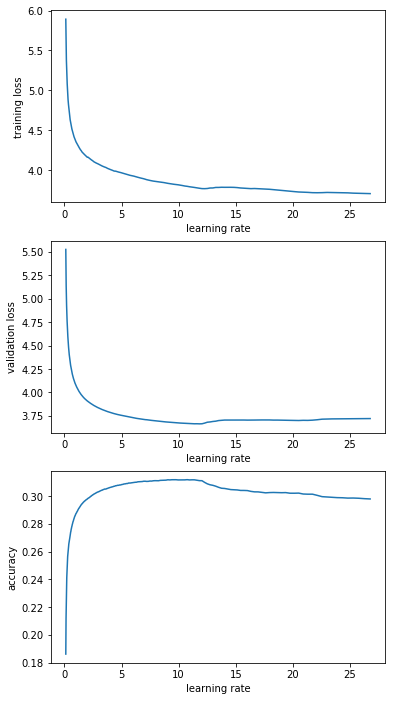

In [20]:
learn.sched.plot()

In [21]:
lr=10
lrs = lr

In [22]:
learn.clip=0.12

In [23]:
learn.fit(lr, 1, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy                 
    0      4.853143   3.974472   0.288784  
    1      4.339055   3.731294   0.297303                 
    2      4.065951   3.656287   0.305585                 
    3      3.859634   3.580975   0.316899                 
    4      3.701328   3.558885   0.314969                 
    5      3.558439   3.542998   0.31929                  
    6      3.437419   3.539674   0.322704                 
    7      3.340056   3.527992   0.325185                 
    8      3.278157   3.538889   0.322388                 
    9      3.234205   3.536332   0.323139                 


[array([3.53633]), 0.32313938438892365]

In [24]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

In [25]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

## Classifier tokens

In [26]:
chunksize=24000

re1 = re.compile(r'  +')

In [27]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [31]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

In [32]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [33]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [34]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

In [35]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [36]:
itos = pickle.load((TASSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

3654

In [37]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [38]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Classifier

Parameters here were obtained from imdb notebook from fastai

In [39]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [40]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [41]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [42]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [43]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TASSLM_PATH, trn_dl, val_dl)

In [44]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8

In [45]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [46]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [47]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [48]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [49]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [50]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [51]:
learn.freeze_to(-1)

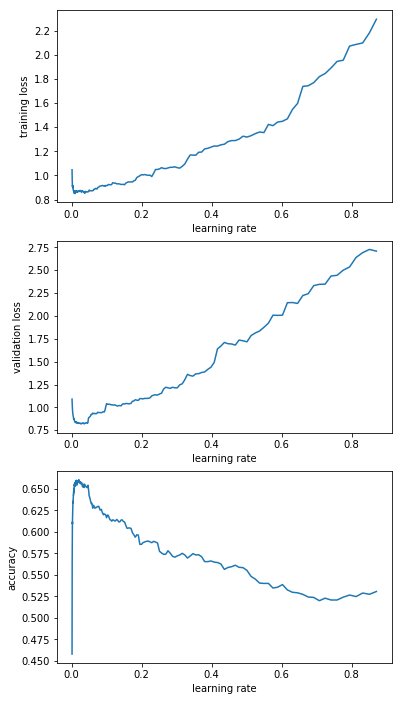

In [307]:
learn.lr_find2(start_lr=1e-3,end_lr=1, num_it=300)
learn.sched.plot()

In [52]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy                    
    0      0.854413   0.780801   0.670608  


[array([0.7808]), 0.6706081129409172]

In [53]:
learn.save('clas2_0')

In [54]:
learn.load('clas2_0')

In [55]:
learn.freeze_to(-2)

In [56]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy                    
    0      0.803827   0.764925   0.668919  


[array([0.76492]), 0.6689189205298552]

In [57]:
learn.save('clas2_1')

In [58]:
learn.load('clas2_1')

In [59]:
learn.unfreeze()

In [60]:
learn.fit(lr, 1, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2')

epoch      trn_loss   val_loss   accuracy                    
    0      0.771125   0.739136   0.684122  
    1      0.743302   0.710845   0.690878                    
    2      0.681867   0.717573   0.717905                    
    3      0.580824   0.727107   0.717905                    
    4      0.521518   0.730092   0.716216                    


[array([0.73009]), 0.7162162065505981]

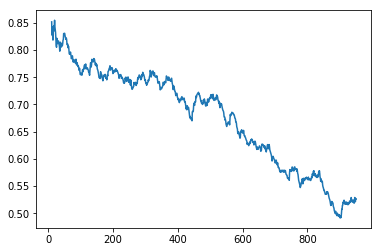

In [61]:
learn.sched.plot_loss()

The previous state of the art result was 70% accuracy (30% error).

## Check F1 score

We load the model with the corresponding weights and parameters

In [62]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

We perform predictions on each of the val_sets texts as per [Matthias Bachfischer's script](https://github.com/Bachfischer/german2vec/blob/master/src/sb-10k-use_pretrained_language_model.ipynb)

In [63]:
# load test set tokens
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

# load classification model weights
learn.load('clas2')
m = learn.model

# set batch size to 1
m[0].bs=1

i = 0
results = []
while i < len(tok_tst):
    sen = ' '.join(tok_tst[i])
    i+=1
    m.eval()
    # reset hidden state
    m.reset()
    idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
    idxs = np.transpose(idxs)
    # get predictions from model
    p = m(VV(idxs))
    print(sen + ': ' + str(to_np(torch.topk(p[0],1)[1])[0]))
    # append classification to list of results for validation
    results.append(torch.topk(p[0],1)[1].data.tolist()[0])


 xbos gracias , gracias , gracias a todos cuantos habéis seguido confiando en nuestro camino . ahora toca seguir trabajando por andalucia .: [0]

 xbos buenos días , ¡ domingo de resurrección ! buen día para decidir seguir a jesús , el único que puede salvar de tus pecados .: [0]

 xbos ojalá que int_string 2012 sea el año de la erradicación de otra clase de terrorismo , el de la violencia machista hash_tag # mensajegriñan: [1]

 xbos t_up csif se felicita de que slang_string sólo les hayan congelado ; el gob cat , molesto por slang_string quedarse sólo . lo comentamos user_ref en user_ref 20:30: [1]

 xbos en un pueblo de valencia agreden a periodistas por grabar tradición de lanzar ratas hyp_link . ( via user_ref ): [1]

 xbos hash_tag # gallardón : la policía ha actuado obligada por slang_string violencia provocada.desde que slang_string es ministro se ha quitado careta ideológica hyp_link: [1]

 xbos con una ley de transparencia como pide user_ref esto no habría pasado : valencia 


 xbos amaiur no cumple los requisitos y no tendrá grupo parlamentario: [1]

 xbos rubalcaba pide " una subida de impuestos selectiva " , a quienes más tienen y a grandes empresas hash_tag # investidura: [1]

 xbos la ducha escocesa en que slang_string se mueve nuestra economía ( optimismo / pesimismo ) puede durar mucho tiempo . momento de slang_string dudas y signos contradictorios .: [1]

 xbos se recomienda a rosa díez foniatra al canto , con ese tono de voz le van a salir unos pólipos como monaguillos si no se cuida .: [1]

 xbos esas empresas " modelo " ? rt user_ref google , apple y microsoft pagan impuestos mínimos fuera de ee uu hyp_link vía user_ref: [1]

 xbos bueno , resfriados estamos muchos .. pero a coruña es bella incluso estando gris . rt user_ref ( cont ) hyp_link: [0]

 xbos la audiencia vuelve a imputar a bárcenas , merino y galeote . veamos si cospedal es tan buena arquitecta como trillo con la justicia .: [1]

 xbos tk_wrep 5 user_ref buenas noches ;-) ) a ver si 


 xbos mi artículo en t_up esd : " la cita de camps y rajoy y la ' mala leche ' de fabra " hyp_link: [1]

 xbos rajoy trae la lluvia a asturias , dicen que no llovía hace tiempo: [1]

 xbos y la igualdad de hash_tag # oportunidades para conseguir mejorar los niveles educativos de la hash_tag # comunidad autónoma: [0]

 xbos covergència , después de su congreso , ha marcado claro su objetivo : llevar a cataluña al conflicto social desde la insumisión de slang_string coche oficial: [0]

 xbos un buen trabajo ... “@lavanguardia : la t_up nasa busca astronautas para ir a un asteroide hyp_link: [0]

 xbos no , el jefe de prensa de morenés no soy risa_ja yo , jaja .: [1]

 xbos en sevilla ratificaremos nuestra condición de slang_string lideres y mañana neymar nos hara disfrutar mucho: [0]

 xbos una lástima no poder estar el 4 / 2 en la de despedida de palermo . justo homenaje para alguien que slang_string se merece todo hyp_link: [0]

 xbos la cuesta de enero es la crisis deluxe .: [1]

 xb


 xbos si los andaluces y andaluzas así lo quieren el 26-m habrá otra forma de gobernar en andalucía que slang_string trabajará desde el minuto uno por slang_string esta tierra .: [1]

 xbos miniempleos , mini - presupuestos , mini- sanidad y mini - educación públicas , mini - impuestos a ricos para macro- beneficios y macro - especulación: [0]

 xbos hash_tag # elcambioandaluz el pp denuncia que “ la junta deja abandonados a su suerte a miles de erasmus ” : ... hyp_link user_ref: [1]

 xbos me gusta :) rt user_ref por qué decidí escribir un blog sobre hash_tag # periodismo y qué leo para hacerlo hyp_link: [0]

 xbos menéame ( si quieres ) : las excusas de wert hyp_link: [1]

 xbos user_ref perdona , he querido decir el friki , el ipad escribe lo que le da la gana: [0]

 xbos por si no os queréis enterar ya he lamentado la muerte por huelga de slang_string hambre del disidente cubano y he defendido el respeto de todos los t_up ddhh: [1]

 xbos salimos hacia madrid porque mañana hay par


 xbos me encanta risa_ja risa_jo “ @julianrojaso : just posted a photo hyp_link: [0]

 xbos con user_ref los tiempos que slang_string vienen son de construcción , confianza , colaboración y corresponsabilidad para levantar nuestra tierra .: [0]

 xbos hash_tag # gobiernorajoy lo de sobradamente preparados es una ironía por la portada de user_ref cuanto peloteo de pedro j. para hacerse perdonar: [1]

 xbos user_ref muchas gracias ... pero seguro que no mejor que tú el próximo . mucha suerte y a exprimir el viaje !: [0]

 xbos por que le tienen que pegar patadas a las papeleras los que están cerrando los bares ? no lo entiendo , de verdad que no lo entiendo: [1]

 xbos merkel persiste en el error . lo explica user_ref en su análisis " el euro en la encrucijada " . hyp_link: [1]

 xbos t_up gracias t_up león ! ! ! t_up gran t_up noche ! ! !: [0]

 xbos entramos ya tk_rep 4 ! user_ref 20:30 no somos telesucesos , si quiere información con criterio , este es su telediario . vamos tk_rep 5 


 xbos buenos días a todos , que tengáis un buen lunes y una estupenda semana :-): [0]

 xbos el estratega de sarkozy dice que ganará como " el candidato de la europa de las fronteras " ... lo que va a tener que destruirse para que gane .: [1]

 xbos igualmente ;-) ) rt user_ref user_ref user_ref un beso enorme y hash_tag # felicesfiestas :-)): [0]

 xbos bdías . hoy ha tocado madrugar . mi carta de mañana será provocadora . espero que os guste . ¿ qué os parece el primer presupuesto de rajoy ?: [0]

 xbos alemania aislada ante la ministerial t_up g20 sobre su resistencia para ampliar el fondo de rescate.spiegel hyp_link: [1]

 xbos mi abrazo y toda la fuerza para user_ref: [0]

 xbos curioso rt user_ref ¿ os venís de hash_tag # tweetpatrulla ? queremos celebrar el día de la mujer . int_string 2 mujeres de la policía tuitearán su trabajo: [0]

 xbos móvil off y a descansar un poquito ... si es posible ... : ) hasta luego !: [0]

 xbos “ @garciaaller : el país justifica así su articulo 


 xbos glups tk_rep 4 ! rt user_ref el miedo es la nostalgia de lo que aún se tiene .: [1]

 xbos entre esta semana y la que viene seguro que anunciaremos la gira acústica de méxico . besos .: [0]

 xbos como miles con zapatos nuevos hyp_link: [0]

 xbos hash_tag # jueveslaico ya es trending topic . gracias .: [0]

 xbos a quien no le guste que no lo vea tk_rep 5 !: [1]

 xbos ;-) ) rt user_ref user_ref user_ref int_string 5 mujeres y int_string 4 hombres , me gusta ;): [0]

 xbos damasiado frío alonso ( t_up psoe ) en sus críticas al hash_tag # rajoynazo1 parece un técnico , no un político .: [1]

 xbos portada de ' público ' , jueves . bonificaciones a bancos por no desahuciar ; diccionario biográfico alternativo . hyp_link: [1]

 xbos lo de hash_tag # urdangarin . entre urdangas , garzones y carcaños así vamos . y la siguiente de hash_tag # garzon , por trincón.caro emilio hyp_link: [1]

 xbos veo que no se abre el link de la noticia del ayto de t_up bcn . vuelvo . hyp_link: [1]

 x


 xbos ¿ en qué se supone que ha cedido merkel en esta " dura negociación " ?: [1]

 xbos “ @martinbravo_a : el arzobispo de valladolid desmiente lo publicado y lamenta actitud de user_ref hyp_link cc : user_ref: [1]

 xbos hash_tag # andalucia necesita claridad en sus cuentas , transparencia y rigor . por eso es tan necesario hash_tag # elcambioandaluz: [1]

 xbos un juez denuncia " hacinamiento " en un centro para ' sin papeles ' hyp_link: [1]

 xbos hoy se levanta el secreto de sumario sobre el caso campeón . conoceremos los elementos para la imputación del ex ministro josé blanco .: [1]

 xbos los dos nombramientos de rajoy son de mano dura con guante de plata . a posada dará bien la talla , guiño a castilla y león .: [1]

 xbos comienza la comparecencia del ministro en la comisión de agricultura , pesca y medio ambiente .: [0]

 xbos zarrias en la nueva ejecutiva nacional del psoe tk_rep 4 . sin palabras: [0]

 xbos de guindos cifra en 4.000 millones el ajuste que aprobará este vi

In [64]:
preds = np.asarray(results)

In [65]:
from sklearn.metrics import *
# f1 score for all three classes
f1_score(tst_labels, preds, average='macro')

0.5496455767273748

SOTA is: 0.562. Source: http://ceur-ws.org/Vol-1896/p0_overview_tass2017.pdf